<h2>ANN regression example 2 - Housing data with preprocessing</h2>

In [1]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

In [2]:
# load the data
df = pd.read_csv("Housing.csv")

In [4]:
# let's see what we have in the data
df.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished


<p>We can see in the data that we have many yes/no fields and one field with multiple text categories. We have to convert all of these correctly into numeric format.</p>

In [5]:
# quickly check if we have missing values
df.isna().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

<h3>Convert no/yes -columns into 0/1</h3>

In [6]:
# this just converts the value of column to 0 or 1
# factorize in pandas works too, but only one column at a time
from sklearn.preprocessing import LabelEncoder
variables = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

In [7]:
# works nicely!
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


<h3>Convert text categories with multiple choices into multiple variables</h3>

In [8]:
# this makes multiple columns with the variable (Separate for yes/no)
from sklearn.preprocessing import OneHotEncoder

# we only have one of these categories in this data
variables = ['furnishingstatus']
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [10]:
# works nicely
df.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0,0
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,0,1,0
6,10150000,8580,4,3,4,1,0,0,0,1,2,1,0,1,0
7,10150000,16200,5,3,2,1,0,0,0,0,0,0,0,0,1
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,1,0,0
9,9800000,5750,3,2,4,1,1,0,0,1,1,1,0,0,1


In [11]:
# when converting a category with multiple options
# into multiple variables, we can always remove the last one of them
# for the optimizations. See the ANN regression materials why this works 
# (the Rovaniemi/Oulu/Helsinki -example)
df = df.drop("furnishingstatus_unfurnished", axis=1)

In [13]:
df.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,0,1
6,10150000,8580,4,3,4,1,0,0,0,1,2,1,0,1
7,10150000,16200,5,3,2,1,0,0,0,0,0,0,0,0
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,1,0
9,9800000,5750,3,2,4,1,1,0,0,1,1,1,0,0


In [14]:
# printing out the column names for easier copying for X/y
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus_furnished',
       'furnishingstatus_semi-furnished'],
      dtype='object')

<h3>X/y -variables</h3>

In [15]:
# if you  have more than one independent variables, list them all here
# leave out the target variable! (dependent variable)
# in this case, everything else except the amount_paid
X = df[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus_furnished',
       'furnishingstatus_semi-furnished']]

# have only the target variable here (dependent variable)
# in this case, amount_paid => how big is the electricity bill
y = df['price']

<h3>Train/test/validation -split</h3>

In [16]:
# unfortunately the scikit-learn's train_test_split doesn't support validation
# set split in itself.
# if you want to split the test set into two for a validation set too, try this trick:

# first, train/test split => 70% for training, 30% for other purposes (temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)

# now, split the 30% for other purposes by 50% (resulting in 2 x 15%)
# so finally, we have:
# 70% for training
# 15% for testing
# 15% for validation
# => 70 + 15 +15 = 100%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)

In [17]:
# just seeing how much data we have in each
print(f"Train data amount: {len(X_train)}")
print(f"Test data amount: {len(X_test)}")
print(f"Validation data amount: {len(X_val)}")

Train data amount: 381
Test data amount: 82
Validation data amount: 82


<h3>Create neural network structure</h3>

In [20]:
variable_amount = len(X.columns)

# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in regression is always 1 node without activation function
model = keras.Sequential(
    [
        layers.Dense(16, activation="relu", input_shape=(variable_amount,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1)
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\tuomas.valtanen\deeplearning2024syksylecturenotes\deeplearning_autumn2024_lecture_notes\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313 (5.13 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 0 (0.00 B)

<h3>Train the neural network with our data</h3>

In [21]:
# using validation again for better metrics and optimization
model.fit(x=X_train, y=y_train, epochs=800, validation_data=(X_val, y_val))

Epoch 1/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 26544070197248.0000 - val_loss: 25234352635904.0000
Epoch 2/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25737000124416.0000 - val_loss: 25230311424000.0000
Epoch 3/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25689428328448.0000 - val_loss: 25225634775040.0000
Epoch 4/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 26822104317952.0000 - val_loss: 25219846635520.0000
Epoch 5/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25417889087488.0000 - val_loss: 25212250750976.0000
Epoch 6/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24247887986688.0000 - val_loss: 25202670960640.0000
Epoch 7/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25468761800704.0000 - val_loss: 25190792691712.0000
Epoch 8/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25830593921024.0000 - val_loss: 25175175200768.0000
Epoch 9/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24022773399552.0000 - val_loss: 25154576973824.0000


<h3>Training metrics</h3>

<Axes: >

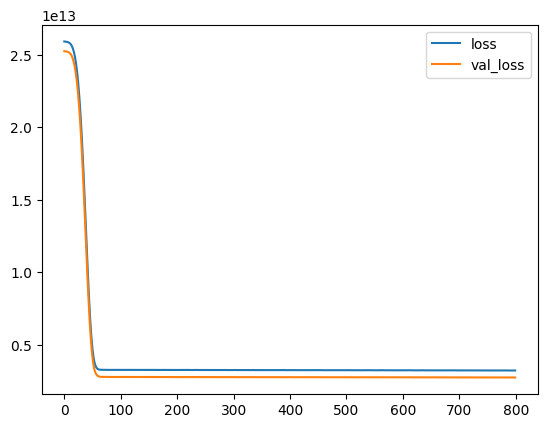

In [22]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [23]:
# compare test error values to training error values
# the model is often good when these error values are similar
# even if you training metrics above didn't overlap
# you might still get very close values in evaluation => more important

# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
4239940386816.0

Train data evaluation:
3212997033984.0


<h3>Make some test predictions to see what kind of mistakes the model makes</h3>

In [24]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


,Test True Y,Model Predictions
0,7140000,5156393.00
1,4620000,2491117.75
2,8855000,5519106.00
3,2100000,2593467.00
4,4095000,3476342.50
...,...,...
77,3773000,7059442.50
78,4480000,3450683.00
79,4305000,8849769.00
80,4375000,3354102.75


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

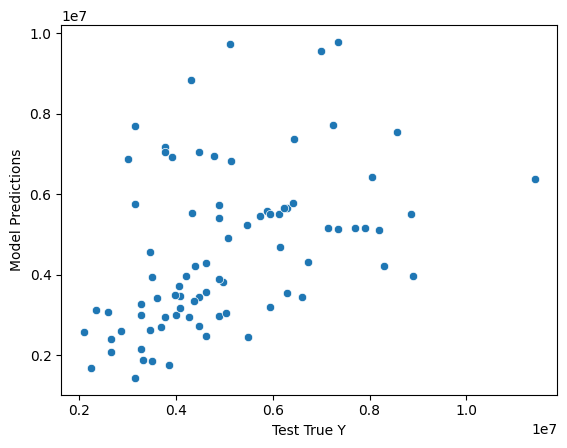

In [25]:
# these values follow a linear line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

<h3>Regression error metrics</h3>

In [26]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
1606615.13 $

MSE
4239940827413.57 $^2

RMSE:
2059111.66 $

R-squared:
-0.27

Explained variance score:
-0.22


C:\Users\tuomas.valtanen\AppData\Local\Temp\ipykernel_13880\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


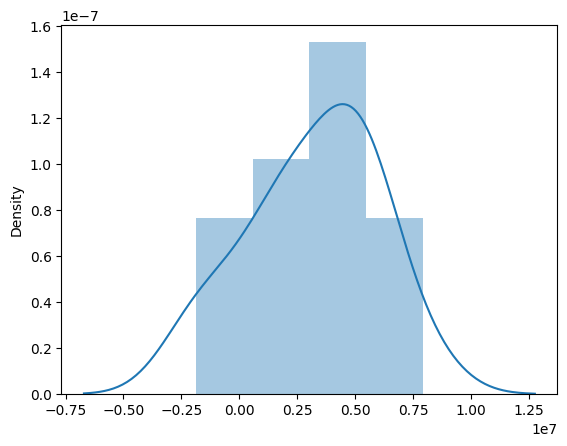

In [27]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

<h2>Lets' try the model in practice</h2>

In [28]:
X.columns

Index(['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom',
       'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea',
       'furnishingstatus_furnished', 'furnishingstatus_semi-furnished'],
      dtype='object')

In [29]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0


In [30]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
    'area': 8500,
    'bedrooms': 4, 
    'bathrooms': 3, 
    'stories': 2,
    'mainroad': 1, 
    'guestroom': 1,
    'basement': 0, 
    'hotwaterheating': 1, 
    'airconditioning': 1, 
    'parking': 2, 
    'prefarea': 0,
    'furnishingstatus_furnished': 0, 
    'furnishingstatus_semi-furnished': 0
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [31]:
result = model.predict(tester_row)[0]

print()
print(f"Estimated price for this house:")
print(f"{round(float(result[0]), 2)} $")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Estimated price for this house:
7299500.5 $
----------------


In [ ]:
len(y_test)